**Title: Star Classification**

In [57]:
#Load all libraries and set plot dimensions
set.seed(2022)
options(repr.plot.height = 8, repr.plot.width = 10)
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)

#Load data frame and changed the column names to more convenient
url <- "https://docs.google.com/spreadsheets/d/e/2PACX-1vR0bAqJh1jznOVyOZbHPL3kLbFjX6YzCWwMh3vMZEeBZq95tdDfcN9vqDP6XUf2j167vXr4oxnDvhb4/pub?gid=1536482276&single=true&output=csv"
star <- read_csv(url)

star_data <- star %>% 
    mutate("Star color" = as_factor("Star color"),
           "Spectral Class" = as_factor("Spectral Class")) %>%
    rename(star_type = "Star type",
           star_color = "Star color",
           spectral_class = "Spectral Class",
           temperature = "Temperature (K)",
           radius = "Radius(R/Ro)",
           luminosity = "Luminosity(L/Lo)",
           absolute_magnitude = "Absolute magnitude(Mv)") %>%
    tibble()


#Renamed numerical values of star type to their actual name 
star_data$star_type[star_data$star_type == 0] <- "Brown Dwarf"
star_data$star_type[star_data$star_type == 1] <- "Red Dwarf"
star_data$star_type[star_data$star_type == 2] <- "White Dwarf"
star_data$star_type[star_data$star_type == 3] <- "Main Sequence"
star_data$star_type[star_data$star_type == 4] <- "Super Giant"
star_data$star_type[star_data$star_type == 5] <- "Hyper Giant"

#Changed star_type to a factor and also applied log10 function to all predictors
star_data <- star_data %>%
    mutate(star_type = as_factor(star_type),
          luminosity = log10(luminosity),
          radius = log10(radius),
          temperature = log10(temperature))

Parsed with column specification:
cols(
  `Temperature (K)` = col_double(),
  `Luminosity(L/Lo)` = col_double(),
  `Radius(R/Ro)` = col_double(),
  `Absolute magnitude(Mv)` = col_double(),
  `Star type` = col_double(),
  `Star color` = col_character(),
  `Spectral Class` = col_character()
)



In [58]:
#Split the data into a training set and testing set 
star_split <- initial_split(star_data, prop = 0.6, strata = star_type)
star_train <- training(star_split)
star_test <- testing(star_split)

In [59]:
#Plot indicating the number of observations in each star type and averages of all predictor variables
star_distribution <- star_train %>%
    select(temperature, radius, luminosity, star_type) %>%
    group_by(star_type) %>%
    summarize(stars_in_class = n(), luminosity_avg = mean(luminosity), radius_avg = mean(radius), temperature_avg = mean(temperature))
star_distribution

`summarise()` ungrouping output (override with `.groups` argument)



star_type,stars_in_class,luminosity_avg,radius_avg,temperature_avg
<fct>,<int>,<dbl>,<dbl>,<dbl>
Brown Dwarf,24,-3.332589,-0.9463101,3.479225
Red Dwarf,24,-2.571799,-0.4970268,3.521134
White Dwarf,24,-3.120460,-1.9725190,4.120649
Main Sequence,24,2.075137,0.4313693,4.060706
Super Giant,24,5.412086,1.6842964,4.093484
Hyper Giant,24,5.458655,3.1236641,3.862268


**Table 1**

Table 1 shows that we don't need a majority classifier since we have an even distribution of all star types

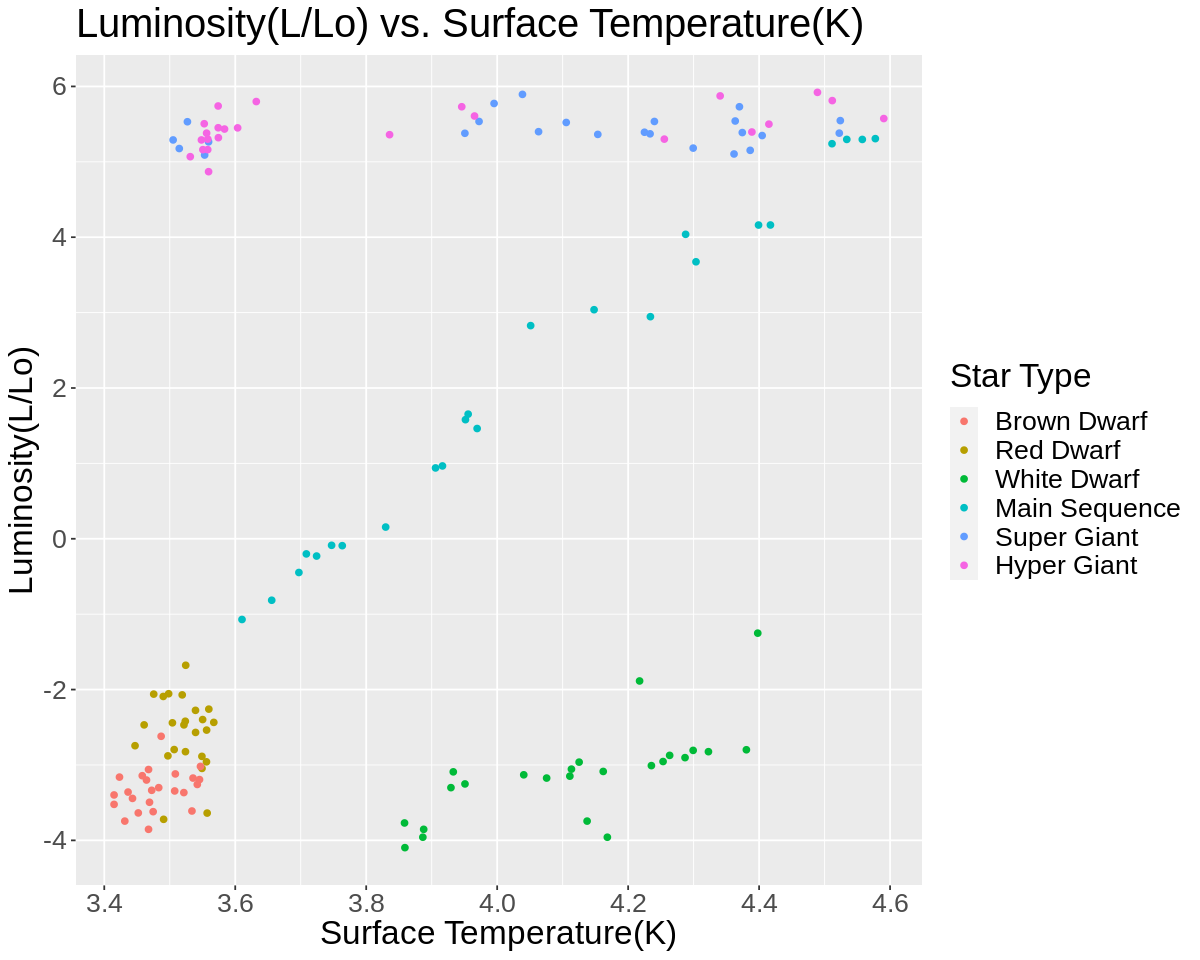

In [60]:
#Visualization of Luminosity(L/Lo) vs. Temperature(K)
star_plot <- star_train %>%
    ggplot(aes(x = temperature, y = luminosity, color = star_type)) + 
    geom_point() +
    ggtitle("Luminosity(L/Lo) vs. Surface Temperature(K)") +
    labs(x = "Surface Temperature(K)", y = "Luminosity(L/Lo)", color = "Star Type") +
    theme(text = element_text(size = 20))

star_plot 

**Figure 1**

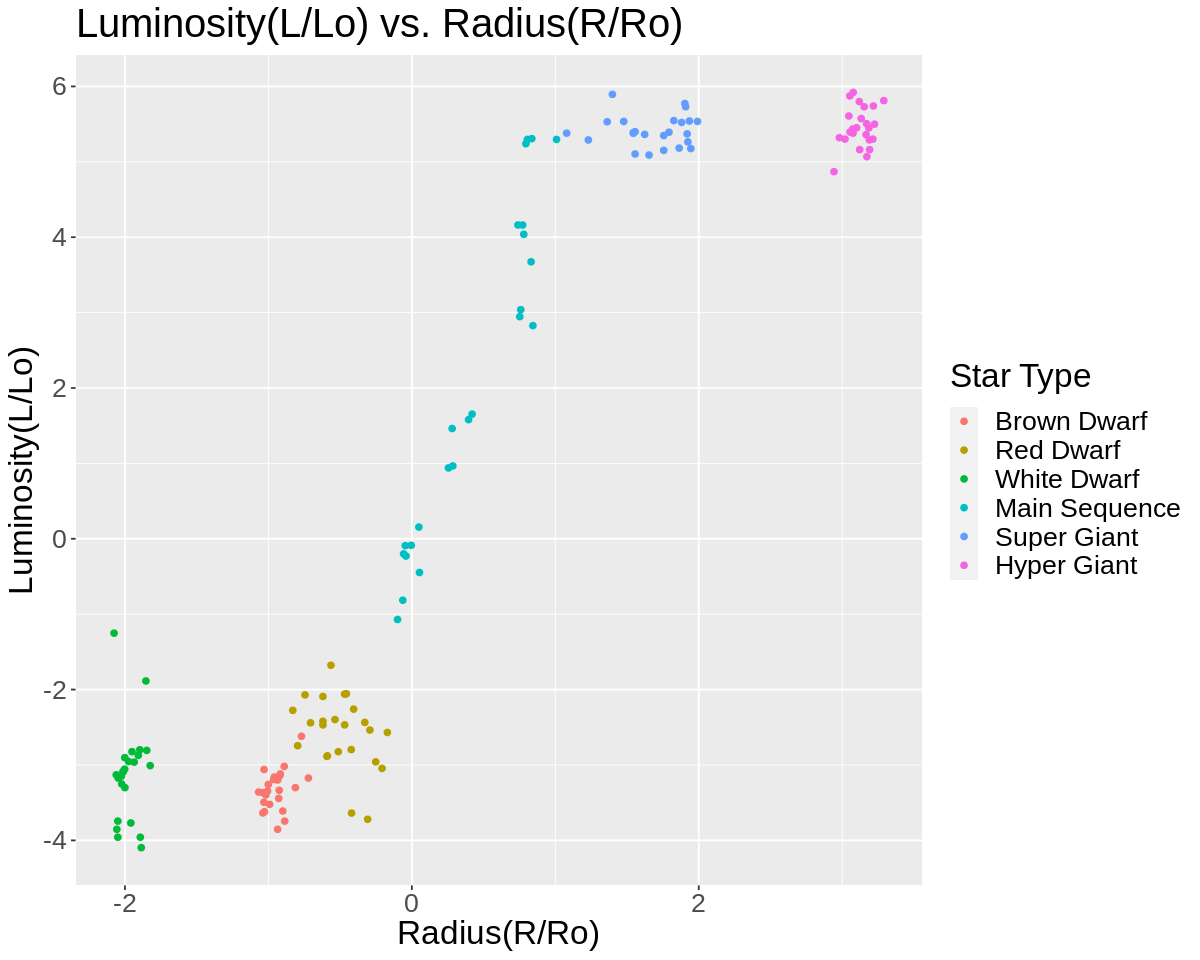

In [61]:
#Visualization of Luminosity(L/Lo) vs. Radius(R/Ro)
star_plot_2 <- star_train %>%
    ggplot(aes(x = radius, y = luminosity, color = star_type)) + 
    geom_point() +
    ggtitle("Luminosity(L/Lo) vs. Radius(R/Ro)") +
    labs(x = "Radius(R/Ro)", y = "Luminosity(L/Lo)", color = "Star Type") +
    theme(text = element_text(size = 20))

star_plot_2

**Figure 2**

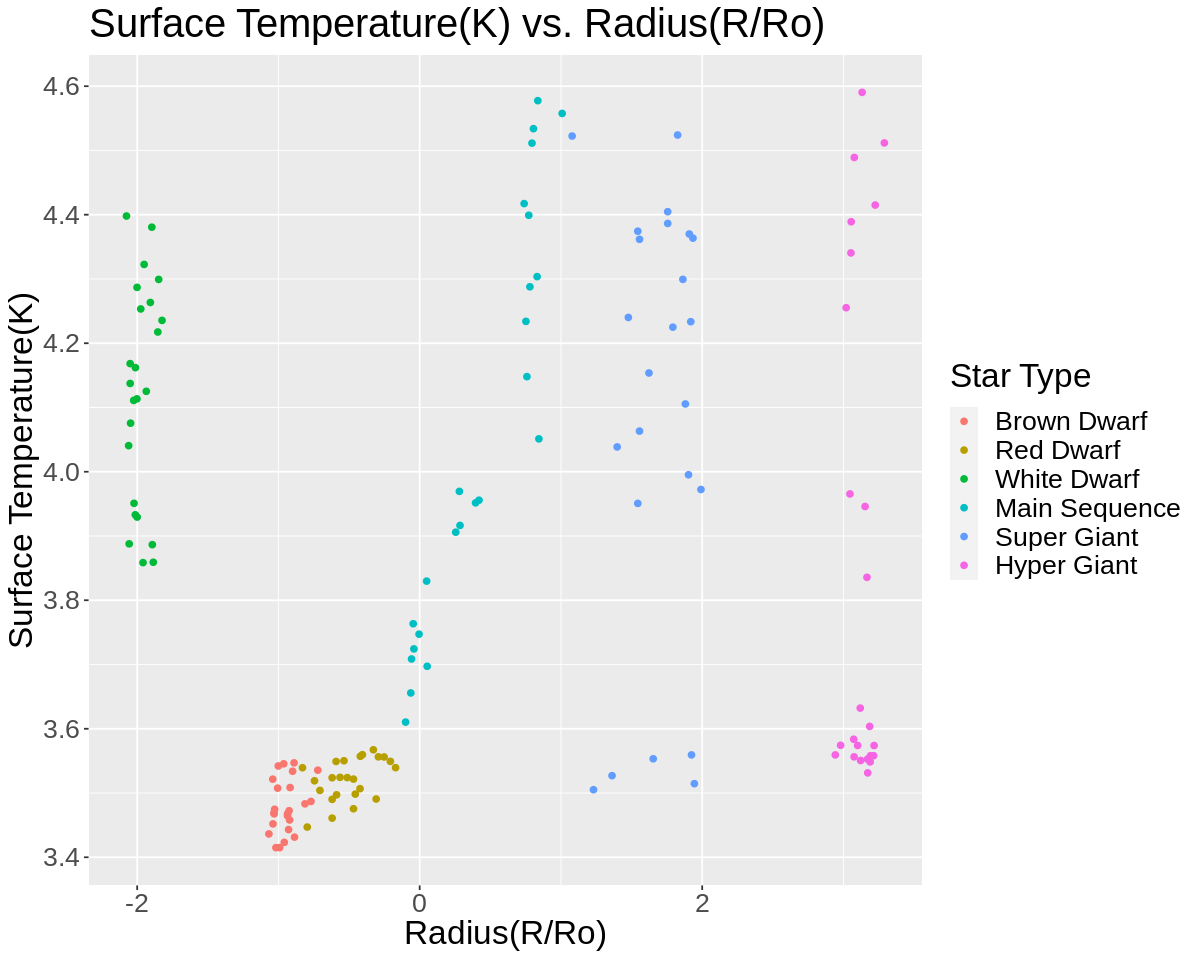

In [62]:
#Visualization of Temperature(K) vs. Radius(R/Ro)
star_plot_3 <- star_train %>%
    ggplot(aes(x = radius, y = temperature, color = star_type)) + 
    geom_point() +
    ggtitle("Surface Temperature(K) vs. Radius(R/Ro)") +
    labs(x = "Radius(R/Ro)", y = "Surface Temperature(K)", color = "Star Type") +
    theme(text = element_text(size = 20))

star_plot_3

**Figure 3**

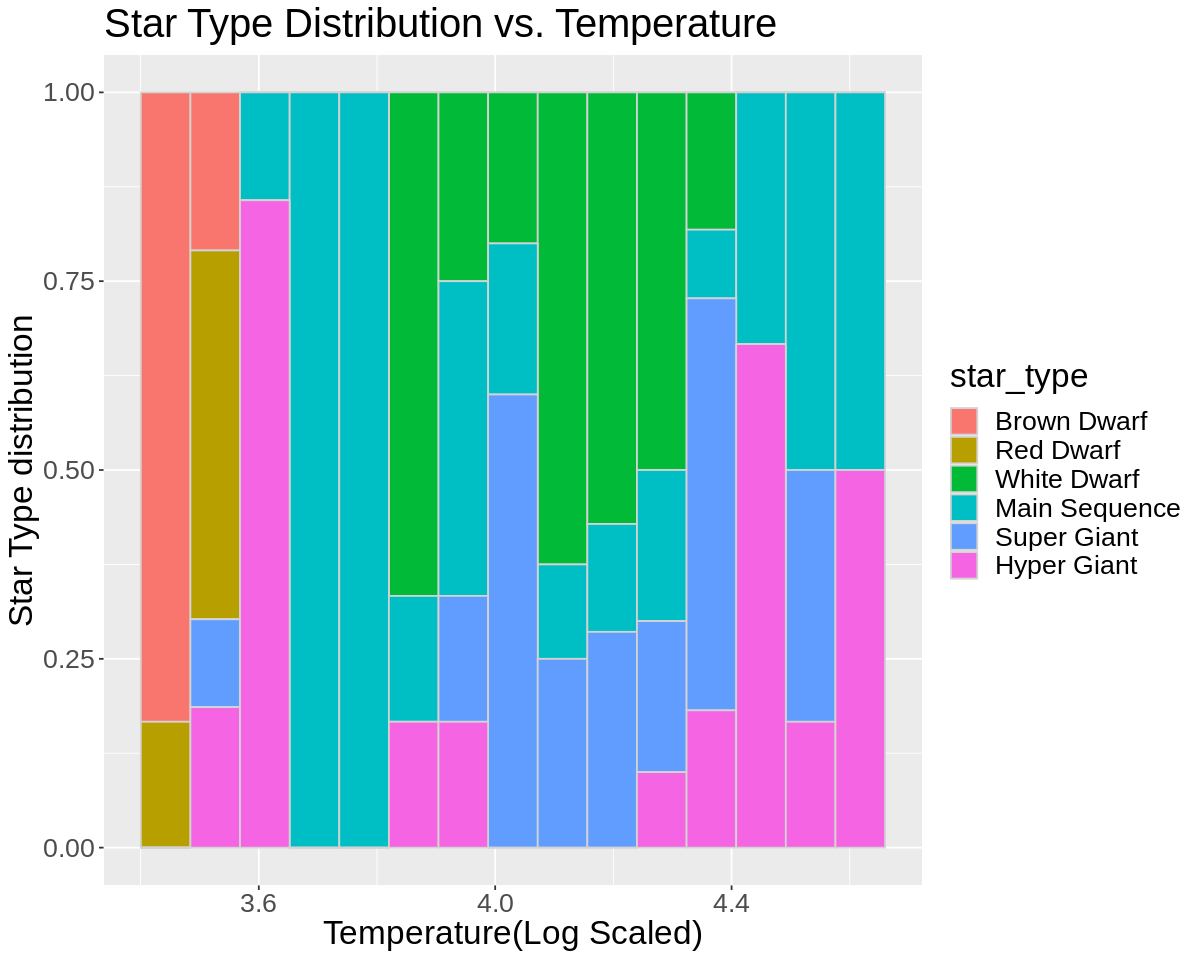

In [63]:
#Plot to see distribution of star type and temperature
star_temp_plot <- star_train %>%
    ggplot(aes(x = temperature, fill = star_type)) +
    geom_histogram(position = "fill", color = "lightgrey", bins = 15) +
    ggtitle("Star Type Distribution vs. Temperature") +
    labs(x = "Temperature(Log Scaled)", y = "Star Type distribution", color = "Star Type") +
    theme(text = element_text(size = 20))

star_temp_plot

**Figure 4**

After observing Figure 1, Figure 3, and Figure 4 it seems like the temperature might not be the best predictor because many different star types can have the same temperature so want to test out a model where we include all predictors with a arbitrary value of K and see how accurate out model is because judging from the figures, star types such as hyper giants and super giants might be misclassified. So lets create a model with k = 5 and using temperature, radius, and luminosity as predictors. We will apply cross validation to determine accuracy because we don't want to touch our test data yet until we build the best model.

In [75]:
#Star Vfold to apply cross-validation
star_vfold <- vfold_cv(star_train, v = 5, strata = star_type)

#K-nearest neighbor model specification: pre cross-validation
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

#Recipe for star data and standardization
star_recipe_temp <- recipe(star_type ~ radius + luminosity + temperature, data = star_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

#Put together everything into a workflow
star_fit <- workflow() %>%
    add_recipe(star_recipe_temp) %>%
    add_model(knn_spec) %>%
    fit_resamples(resamples = star_vfold)

# #Collect the summary of our cross-validation
star_summary_temp <- star_fit %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

star_summary_temp

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.9533333,5,0.02260777


**Table 2**

Our accuracy is quite high with temperature included but we want to test our hypothesis that our model will be better off without including temperature

In [65]:
#K-nearest neighbor model specification: pre cross-validation
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

#Recipe for star data and standardization
star_recipe <- recipe(star_type ~ radius + luminosity, data = star_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

#Put together everything into a workflow
star_fit <- workflow() %>%
    add_recipe(star_recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = star_vfold, grid = tibble(neighbors = seq(1,20)))

# #Collect the summary of our cross-validation
star_summary <- star_fit %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

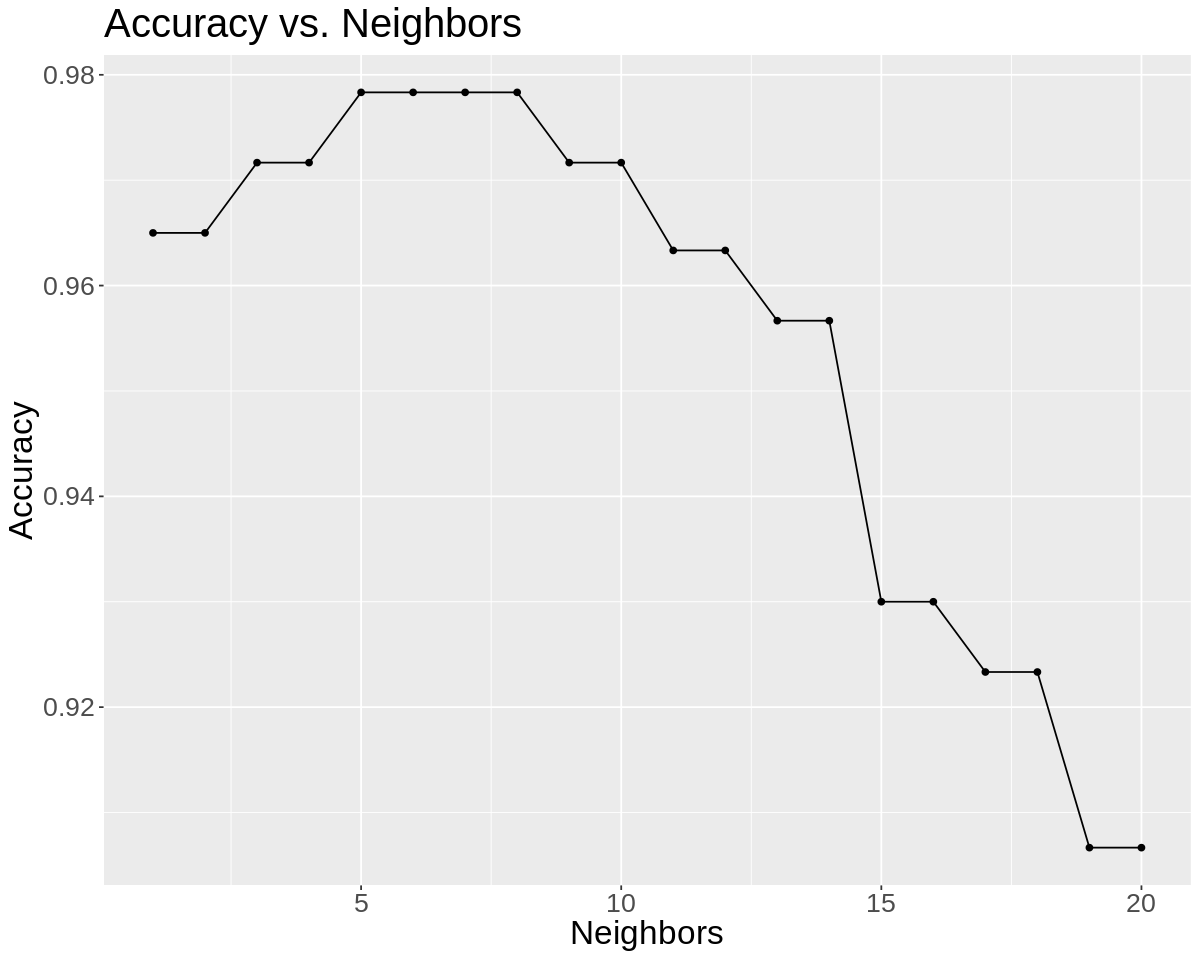

In [66]:
#Plot of accuracy vs. neighbors  
star_accuracy_plot <- star_summary %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() +
    geom_line() +
    ggtitle("Accuracy vs. Neighbors") +
    labs(x = "Neighbors", y = "Accuracy") +
    theme(text = element_text(size = 20))

star_accuracy_plot

**Figure 5**

In [67]:
# #Best K value
# k_min <- star_summary %>%
#     arrange(desc(mean)) %>% 
#     slice(1) %>%
#     select(neighbors) %>%
#     pull()

# k_min

[1] 5

In [68]:
# #Retrained model with new k value 
# knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
#     set_engine("kknn") %>%
#     set_mode("classification") 

# star_best_fit <- workflow() %>%
#     add_recipe(star_recipe) %>%
#     add_model(knn_best_spec) %>%
#     fit(data = star_train) 

In [69]:
# star_metrics <- star_best_fit %>%
#     predict(star_test) %>%
#     bind_cols(star_test) %>%
#     metrics(truth = star_type, estimate = .pred_class)

# star_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9479167
kap,multiclass,0.9375000


**Table 3**

In [70]:
# star_conf_mat <- star_best_fit %>%
#     predict(star_test) %>%
#     bind_cols(star_test) %>%
#     conf_mat(truth = star_type, estimate = .pred_class)

# star_conf_mat

               Truth
Prediction      Brown Dwarf Red Dwarf White Dwarf Main Sequence Super Giant
  Brown Dwarf            16         4           0             0           0
  Red Dwarf               0        12           0             0           0
  White Dwarf             0         0          16             0           0
  Main Sequence           0         0           0            16           1
  Super Giant             0         0           0             0          15
  Hyper Giant             0         0           0             0           0
               Truth
Prediction      Hyper Giant
  Brown Dwarf             0
  Red Dwarf               0
  White Dwarf             0
  Main Sequence           0
  Super Giant             0
  Hyper Giant            16

**Table 4**

In [71]:
# star_best_accuracy <- workflow() %>%
#     add_recipe(star_recipe) %>%
#     add_model(knn_best_spec) %>%
#     fit_resamples(resamples = star_vfold) %>%
#     collect_metrics() %>%
#     filter(.metric == "accuracy")

# star_best_accuracy

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.9783333,5,0.008975275


**Table 5**

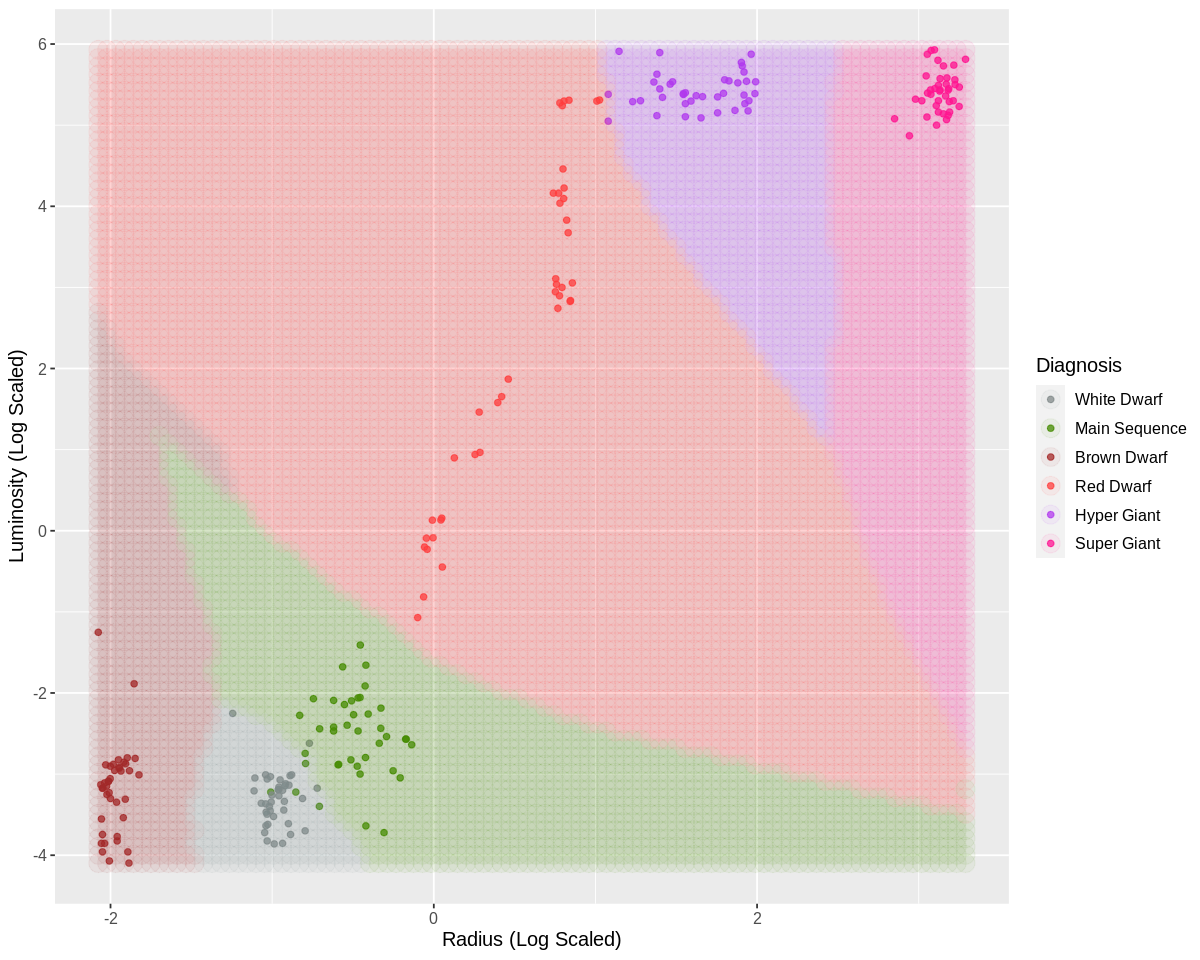

In [72]:
# create the grid of area/smoothness vals, and arrange in a data frame
lum_grid <- seq(min(star_data$luminosity), 
                max(star_data$luminosity), 
                length.out = 100)
rad_grid <- seq(min(star_data$radius), 
                max(star_data$radius), 
                length.out = 100)
asgrid <- tibble(expand.grid(luminosity = lum_grid, 
                                radius = rad_grid))

star_final_fit <- workflow() %>%
    add_recipe(star_recipe) %>%
    add_model(knn_best_spec) %>%
    fit(data = star_train)

knnPredGrid <- predict(star_final_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
  rename(Class = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = star_data, 
             mapping = aes(x = radius, 
                           y = luminosity, 
                          color = star_type), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = radius, 
                           y = luminosity, 
                           color = Class), 
             alpha = 0.06, 
             size = 5) +
  labs(color = "Diagnosis", 
       x = "Radius (Log Scaled)", 
       y = "Luminosity (Log Scaled)") +
  scale_color_manual(labels = c("White Dwarf", "Main Sequence", "Brown Dwarf", "Red Dwarf", "Hyper Giant", "Super Giant"), 
                     values = c("azure4", "chartreuse4", "brown", "brown1", "darkorchid2", "deeppink1")) +
theme(text = element_text(size = 12))

wkflw_plot

**Figure 6**

In [73]:
star_accuracy <- star_best_fit %>%
    predict(star_test) %>%
    bind_cols(star_test) %>%
    mutate(prediction = ifelse(.pred_class == star_type, "correct", "incorrect")) %>%
    group_by(star_type, prediction) %>%
    summarize(n = n())

star_accuracy

`summarise()` regrouping output by 'star_type' (override with `.groups` argument)



star_type,prediction,n
<fct>,<chr>,<int>
Brown Dwarf,correct,16
Red Dwarf,correct,12
Red Dwarf,incorrect,4
White Dwarf,correct,16
Main Sequence,correct,16
Super Giant,correct,15
Super Giant,incorrect,1
Hyper Giant,correct,16


**Table 6**

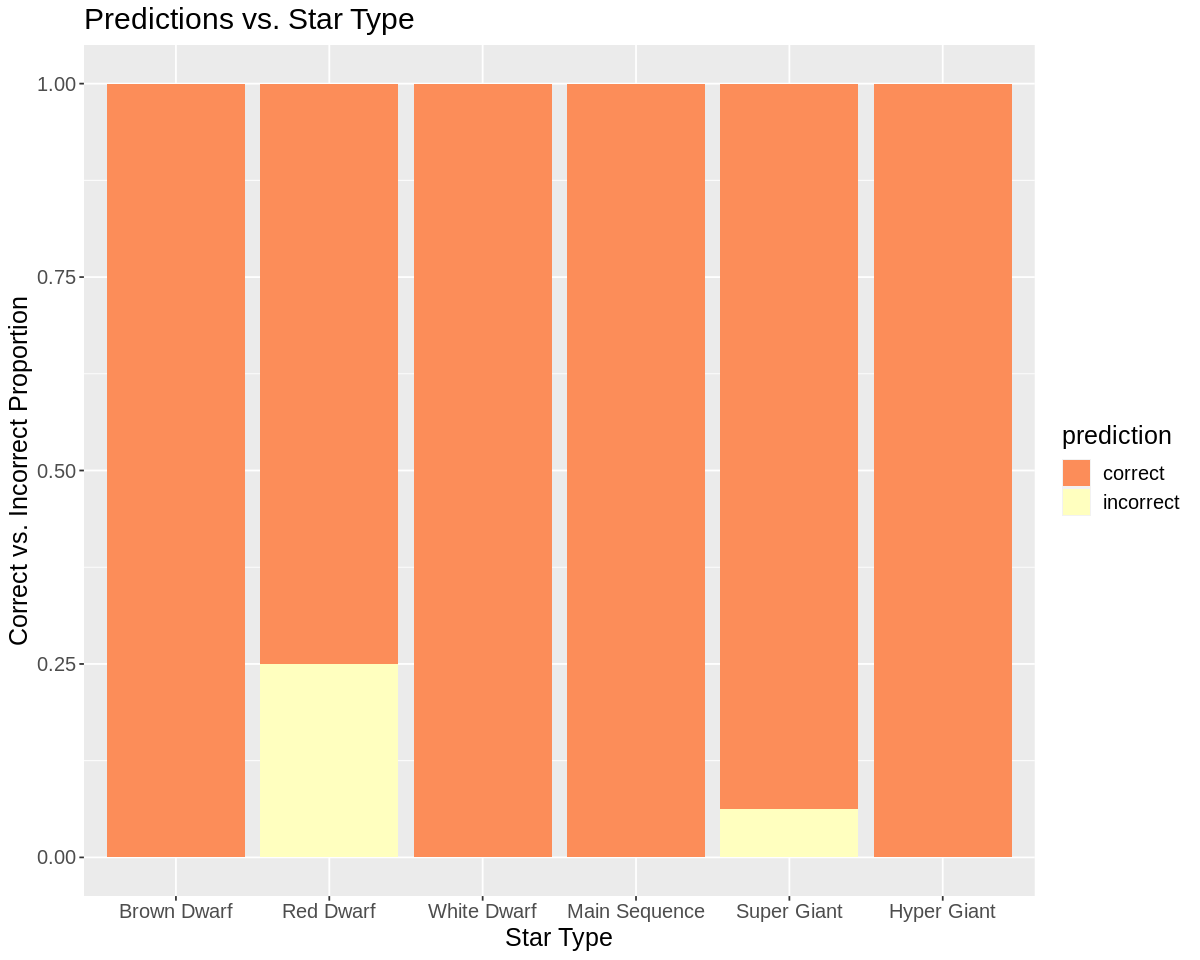

In [74]:
star_accuracy_plot <- star_accuracy %>%
    ggplot(aes(x = star_type, y = n, fill = prediction)) +
    geom_bar(stat = "identity", position = "fill") +
    scale_fill_brewer(palette = "RdYlBu") +
    ggtitle("Predictions vs. Star Type") +
    labs(x = "Star Type", y = "Correct vs. Incorrect Proportion", color = "Predictions") +
    theme(text = element_text(size = 15))

star_accuracy_plot

**Figure 7**